# Old or not

## Business Understanding: 
Van volwassen beroemdheden is het vaak lastig te zeggen hoe oud ze zijn. Nu gaan we kijken of we een neuraal netwerk kunnen bouwen wat dit beter kan schatten dan wij. We nemens als grens de compleet arbitraire waarde van 42 jaar. Iedereen tussen de 21 en 42 noemen we 'not old' en iedereen boven deze grens definieren we als 'old' 

We gebruiken hiervoor de IMDB faces database met daarin meer dan 460.000 gezichten van een dikke 20.000 beroemdheden afkomstig van IMDB (zie https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/ voor uitleg en details) en hierbij de IMDB informatie over o.a. leeftijd en geslacht. We downloaden hier de de cropped IMDB dataset( https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/static/imdb_crop.tar). De metadata wordt in .mat (matlab) bestand meegeleverd. 

- We beperken ons tot volwassen beroemdheden. <u>Iedereen onder de 21 jaar mag je overslaan.</u>
- Er zitten nogal wat foto's met meerdere gezichten of geen gezicht op. <u>Deze mag je eruit filteren</u>
- We verwachten niet alleen de code maar (in het notebook) ook een <u>uitleg</u> van waarom je dingen hebt gedaan. 
- I.v.m. performance issues gebruiken we na opschoning alleen de <u>1e 50.000</u> records als data
- Gebruik <u>20% van je data als testset, gebruik 42 als random state</u>
- Eindig met de mogelijkheid om een jpg van bijv. jezelf in te lezen en d.m.v. het getrainde netwerk te bepalen of diegene wel of niet oud is.

Vul je antwoorden steeds op de juiste plaats in. Maak indien nodig extra cellen aan.

## Data Understanding: 

In [181]:
# Tips:
# - pickle voor tussentijds opslaan

In [182]:
#importeer de juiste packages
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

from sklearn.model_selection import train_test_split

from scipy.io import loadmat

import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import sys

sys.OpenCV_LOADER_DEBUG = True
import cv2


In [183]:
#Lees de metadata in

mat = loadmat("imdb_crop/imdb.mat", squeeze_me=True)

In [184]:
# bestudeer deze en maak voor iedere relevante variabele een aparte list aan
mat: dict = mat
imdb: np.ndarray = mat["imdb"]

(dob, photo_taken, full_path, gender, name, face_location, face_score, second_face_score, celeb_names, celeb_id) = imdb.tolist()

dob1 = dob[0]
print(dob1, type(dob1))

def convertDate(date):
    EPOCH = 719529
    return pd.to_datetime(int(date) - EPOCH, unit='D')

693726 <class 'numpy.int32'>


## Data preparation: 

In [185]:
#Bepaal op basis van de metadata hoe oud de personen op de foto's waren toen deze genomen werden (-1 als onbekend)

age_on_photo = []
# invalids = 0
for i in range(0, len(dob)):
    try:
        date = convertDate(dob[i])
        ageThen = photo_taken[i] - date.year
        age_on_photo.append(ageThen)
    except Exception as e:
        # invalids += 1
        age_on_photo.append(-1)

# print(invalids, "zijn/is ongeldig, dit is", (float(invalids)/len(dob)*100), "procent")
age_on_photo

[69,
 71,
 69,
 69,
 69,
 67,
 80,
 80,
 67,
 80,
 84,
 67,
 50,
 83,
 50,
 82,
 82,
 82,
 82,
 80,
 64,
 80,
 50,
 83,
 50,
 81,
 83,
 83,
 81,
 84,
 83,
 67,
 82,
 82,
 86,
 84,
 66,
 80,
 80,
 67,
 50,
 67,
 80,
 82,
 81,
 67,
 32,
 29,
 29,
 29,
 29,
 29,
 29,
 29,
 29,
 29,
 29,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 28,
 28,
 28,
 28,
 29,
 29,
 29,
 29,
 29,
 32,
 32,
 32,
 32,
 29,
 32,
 85,
 85,
 85,
 85,
 54,
 54,
 54,
 54,
 59,
 59,
 54,
 54,
 63,
 48,
 48,
 48,
 48,
 48,
 48,
 48,
 48,
 48,
 48,
 48,
 48,
 39,
 39,
 39,
 39,
 39,
 39,
 39,
 39,
 77,
 72,
 66,
 86,
 66,
 66,
 66,
 70,
 66,
 66,
 42,
 55,
 43,
 53,
 87,
 40,
 66,
 72,
 72,
 52,
 52,
 52,
 77,
 52,
 70,
 48,
 48,
 48,
 48,
 70,
 70,
 66,
 55,
 66,
 54,
 72,
 38,
 38,
 47,
 43,
 53,
 38,
 41,
 41,
 41,
 38,
 38,
 38,
 38,
 44,
 38,
 44,
 44,
 44,
 38,
 44,
 44,
 44,
 38,
 44,
 38,
 44,
 43,
 38,
 38,
 59,
 59,
 39,
 44,
 44,
 44,
 44,
 38,
 59,
 52,
 39,
 52,
 39,
 59,
 39,
 39,
 52,
 59,
 52,


In [186]:
#voeg de ingelezen metadata en de berekende leeftijd samen tot een nieuwe dataset

df = pd.DataFrame(data={
    'name': name,
    'full_path': full_path,
    'age_on_photo': age_on_photo,
    'face_score': face_score,
    'second_face_score': second_face_score,
})

In [187]:
#schoon de dataset op op basis van de bij de business understanding gegeven criteria.

OLDNESS_THRESHOLD = 42

## Filter: check of mensen minsten 21 jaar oud zijn
df_filtered = df[df['age_on_photo'] >= 21]

## Filter: alleen foto's waar gezichten op gevonden zijn
#       face_score: detector score (the higher the better).
#                   Inf implies that no face was found in the image and the face_location then just returns the entire image
df_filtered = df_filtered[df_filtered['face_score'] != np.Infinity]
df_filtered = df_filtered[df_filtered['face_score'] != -np.Infinity]

## Filter: alleen foto's waar maar een gezicht op staat
##      second_face_score: detector score of the face with the second highest score.
#                          This is useful to ignore images with more than one face.
#                          second_face_score is NaN if no second face was detected.
df_filtered = df_filtered[pd.isna(df_filtered['second_face_score'])]

df_filtered['oldness'] = df_filtered.apply(lambda row: int(row.age_on_photo >= OLDNESS_THRESHOLD), axis=1)

## Filter: max 50000
COUNT = 10000
df_filtered = df_filtered.head(COUNT)

print(f"Gemiddelde oudheid: {df_filtered['oldness'].mean()}")

df_filtered.info()
df_filtered.head()

Gemiddelde oudheid: 0.5613
<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 3 to 24897
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               10000 non-null  object 
 1   full_path          10000 non-null  object 
 2   age_on_photo       10000 non-null  int64  
 3   face_score         10000 non-null  float64
 4   second_face_score  0 non-null      float64
 5   oldness            10000 non-null  int64  
dtypes: float64(2), int64(2), object(2)
memory usage: 546.9+ KB


,name,full_path,age_on_photo,face_score,second_face_score,oldness
3,Fred Astaire,01/nm0000001_rm946909184_1899-5-10_1968.jpg,69,1.872117,NaN,1
4,Fred Astaire,01/nm0000001_rm980463616_1899-5-10_1968.jpg,69,1.158766,NaN,1
6,Lauren Bacall,02/nm0000002_rm1346607872_1924-9-16_2004.jpg,80,3.479189,NaN,1
7,Lauren Bacall,02/nm0000002_rm1363385088_1924-9-16_2004.jpg,80,3.870171,NaN,1
12,Lauren Bacall,02/nm0000002_rm221957120_1924-9-16_1974.jpg,50,4.096431,NaN,1


![img](imdb_crop/01/nm0000001_rm946909184_1899-5-10_1968.jpg)

In [188]:
def readImage(path):
    img = cv2.imread(path)
    # Cursed conversion van BGR naar RGB
    return img[...,::-1]

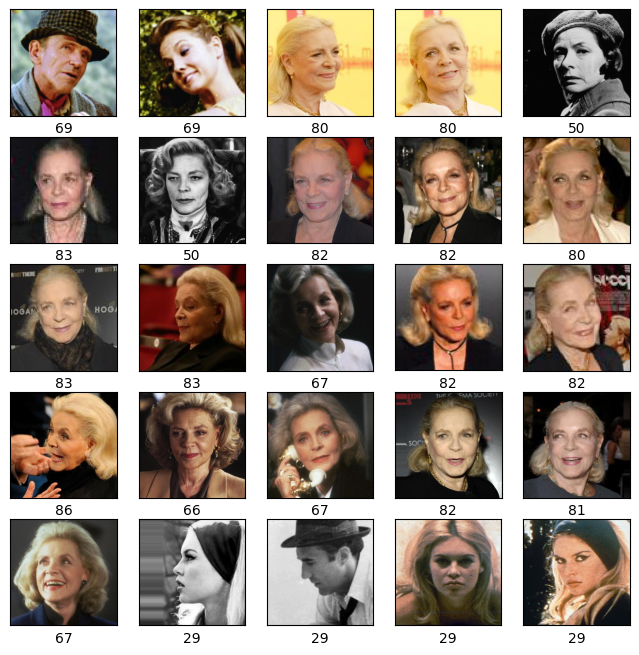

In [189]:
# Lees de afbeeldingen in
images = [readImage("imdb_crop/" + path) for path in df_filtered['full_path']]

plt.figure(figsize=(8,8))
for i in range(25):
    plt.subplot(5,5,i+1)  #vul het i-e image
    plt.xticks([]) #geen schaal bij x-as
    plt.yticks([]) #geen schaal bij y-as
    plt.imshow(images[i]) #orginele plaatjes nodig want de rest zit in een genormaliseerde vector
    plt.xlabel(df_filtered.iloc[i]['age_on_photo'])
plt.show()

In [190]:
widths = np.array([img.shape[0] for img in images])
heights = np.array([img.shape[1] for img in images])

print(f"Width van {widths.min()} naar {widths.max()}")
print(f"Height van {heights.min()} naar {heights.max()}")

Width van 56 naar 501
Height van 56 naar 501


## Modeling: 

In [191]:
WIDTH = HEIGHT = 100
SIZE = (WIDTH, HEIGHT)
images_resized = np.array([cv2.resize(img, SIZE) for img in images])

In [192]:
images_resized_scaled = images_resized / 255.0
# images_reshaped = images_resized_scaled.reshape((COUNT, WIDTH * HEIGHT * 3))
# images_reshaped.shape

In [193]:
ages = np.array(df_filtered['oldness'])
ages.shape

age_on_photos = np.array(df_filtered['age_on_photo'])
age_on_photos.shape

names = np.array(df_filtered['name'])
names.shape

(10000,)

In [194]:
indices = np.arange(0, COUNT)
train_images, test_images, train_ages, test_ages, train_age_on_photos, test_age_on_photos, train_names, test_names, train_indices, test_indices  = train_test_split(images_resized_scaled, ages, age_on_photos, names, indices, test_size=0.2, random_state=42)
ages

array([1, 1, 1, ..., 0, 1, 1])

(100, 100, 3)
(100, 100, 3)
(100, 100, 3)
(100, 100, 3)
(100, 100, 3)
(100, 100, 3)
(100, 100, 3)
(100, 100, 3)
(100, 100, 3)
(100, 100, 3)
(100, 100, 3)
(100, 100, 3)
(100, 100, 3)
(100, 100, 3)
(100, 100, 3)
(100, 100, 3)
(100, 100, 3)
(100, 100, 3)
(100, 100, 3)
(100, 100, 3)
(100, 100, 3)
(100, 100, 3)
(100, 100, 3)
(100, 100, 3)
(100, 100, 3)


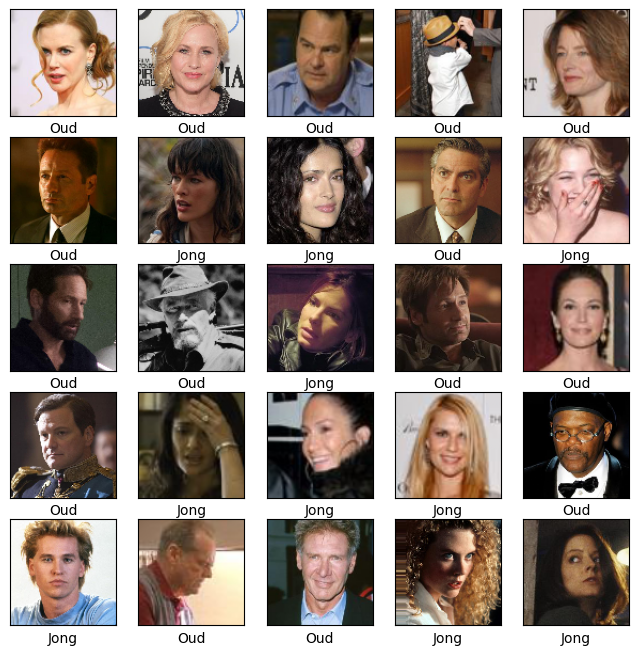

In [195]:
# en valideer dit op de testdata

plt.figure(figsize=(8,8))
for i in range(25):
    plt.subplot(5,5,i+1)  #vul het i-e image
    plt.xticks([]) #geen schaal bij x-as
    plt.yticks([]) #geen schaal bij y-as
    plt.imshow(train_images[i]) #orginele plaatjes nodig want de rest zit in een genormaliseerde vector
    plt.xlabel("Oud" if train_ages.tolist()[i] == 1 else "Jong")
    print(train_images[i].shape)
plt.show()

In [196]:
# train het model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(WIDTH, HEIGHT, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),
    layers.Flatten(),
    layers.Dropout(0.1),
    layers.Dense(10, activation='softmax'),
])


model.compile(optimizer="ADAM",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

train_datagen = ImageDataGenerator(
    # rotation_range=40,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    # vertical_flip=True,
)

data_flow = train_datagen.flow(train_images, tf.reshape(train_ages, (-1)), shuffle=True)
history = model.fit(data_flow, epochs=25, validation_data=(test_images, test_ages))

/opt/anaconda3/envs/tf/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/25


/opt/anaconda3/envs/tf/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


250/250 ━━━━━━━━━━━━━━━━━━━━ 16s 49ms/step - accuracy: 0.5191 - loss: 1.7387 - val_accuracy: 0.4440 - val_loss: 1.7475
Epoch 2/25
250/250 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.5796 - loss: 1.3663 - val_accuracy: 0.6080 - val_loss: 0.8168
Epoch 3/25
250/250 ━━━━━━━━━━━━━━━━━━━━ 12s 47ms/step - accuracy: 0.5913 - loss: 1.2123 - val_accuracy: 0.5715 - val_loss: 1.1963
Epoch 4/25
250/250 ━━━━━━━━━━━━━━━━━━━━ 12s 47ms/step - accuracy: 0.5775 - loss: 1.1820 - val_accuracy: 0.6105 - val_loss: 1.0169
Epoch 5/25
250/250 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.6028 - loss: 0.9076 - val_accuracy: 0.6055 - val_loss: 0.6649
Epoch 6/25
250/250 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.6301 - loss: 0.6762 - val_accuracy: 0.6425 - val_loss: 0.6508
Epoch 7/25
250/250 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.6385 - loss: 0.6452 - val_accuracy: 0.6745 - val_loss: 0.6355
Epoch 8/25
250/250 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.6429 - loss: 0.6329 - val_accurac

In [197]:
# en valideer dit op de testdata


## Evaluation: 

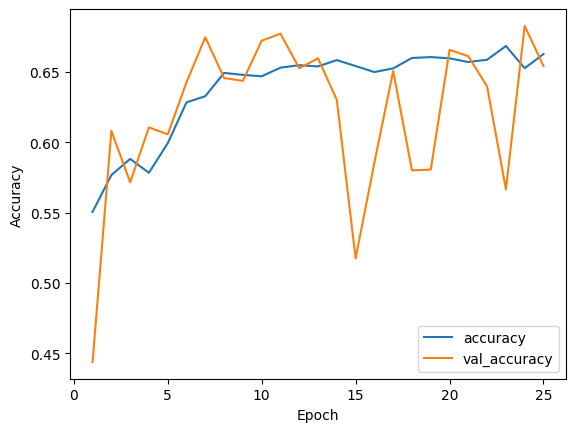

In [198]:
#plot de accuracy en validated accuracy
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
epochs=range(1, len(acc)+1)
plt.plot(epochs, acc, label='accuracy')
plt.plot(epochs, val_acc, label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


<Axes: >

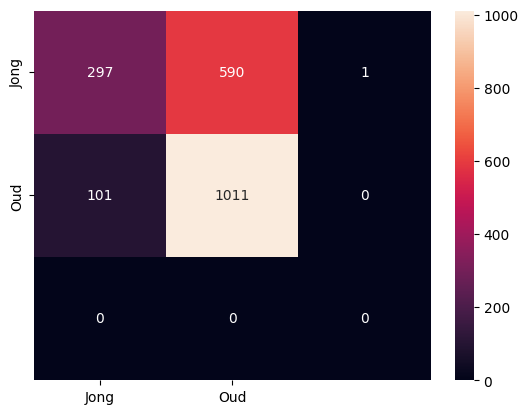

In [199]:
#toon de confusion matrix,
Y_predict= []
predict=model.predict([test_images]) #2d array
for i in range (len(predict)):
    Y_predict.append(predict[i].argmax()) #omzetten zodat ik alleen de max waarde krijg
cm=confusion_matrix(test_ages, Y_predict)
#print(cm) #lelijk maar functioneel

sns.heatmap(cm, annot=True, fmt='d', xticklabels=["Jong", "Oud"], yticklabels=["Jong", "Oud"])
# fmt='g' om te voorkomen dat de wetenschappelijke notatie (3.7e+02) gebruikt.

![Img](imdb_crop/93/nm0000093_rm3278212608_1963-12-18_2009.jpg)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


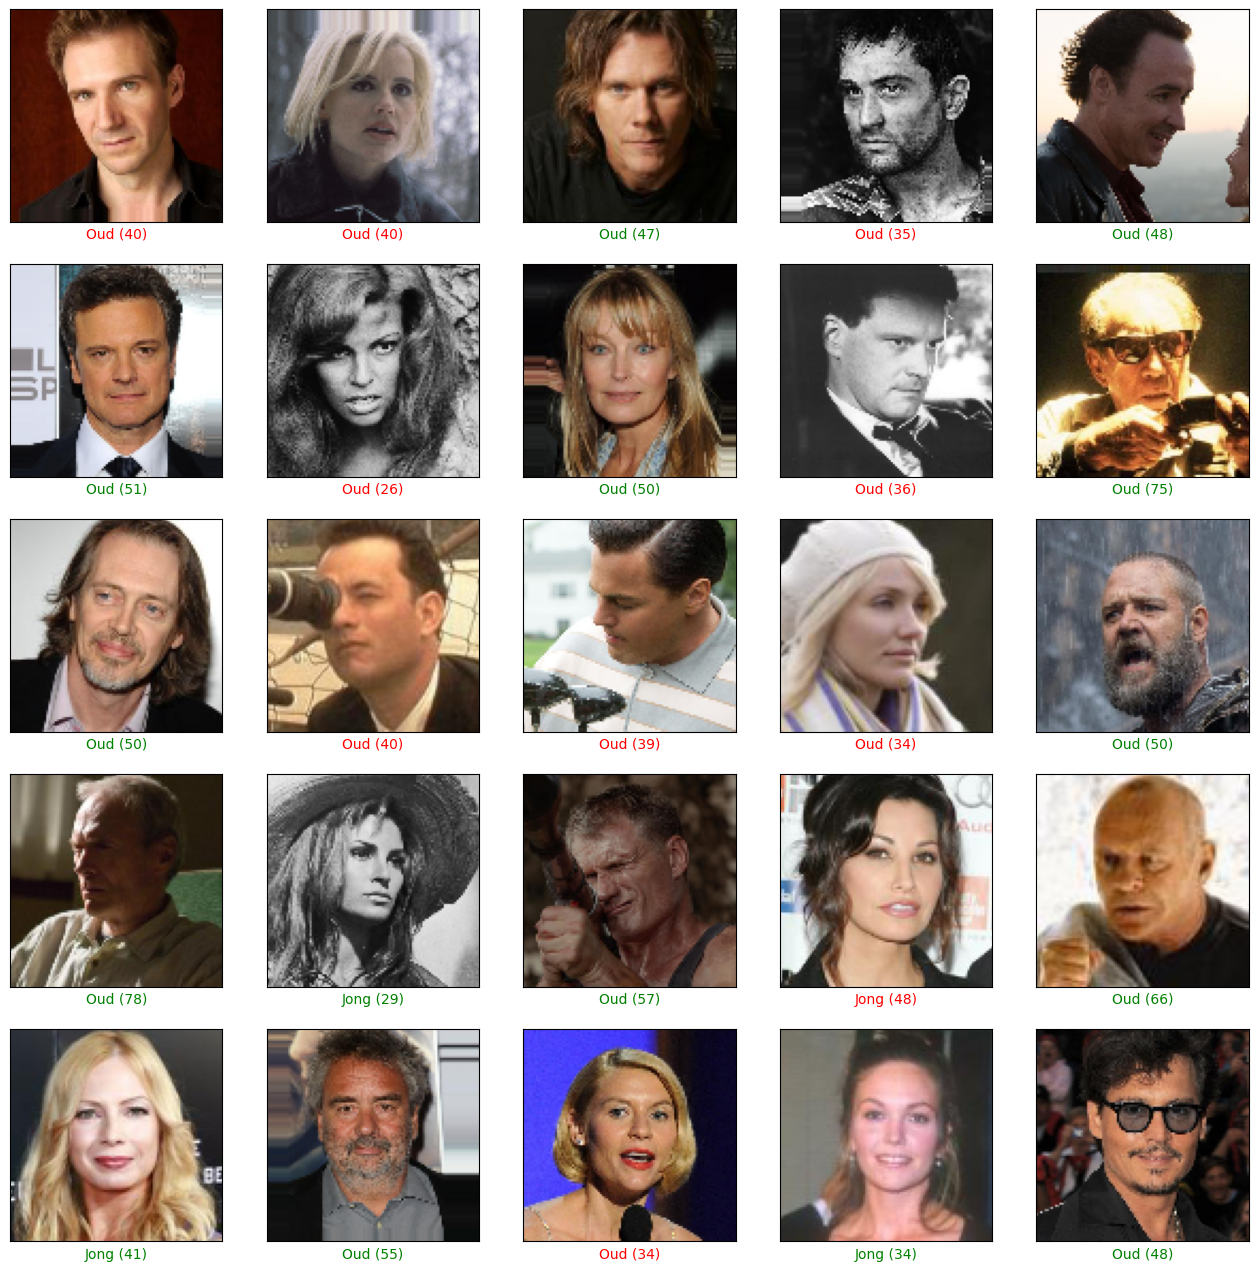

In [200]:
# en toon de een aantal afbeeldingen inclusief of ze volgens het model wel of niet oud zijn,
# doe dit laatste ook voor een paar eigen afbeeldingen


predict = model.predict(test_images[0:25])

predict.shape
plt.figure(figsize = (16, 16))
for i in range(25):
    ax = plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(test_images[i])

    prediction = round(predict[i].argmax())
    actual = round(test_ages[i])

    label = "Oud" if prediction == 1 else "Jong"
    label += f' ({test_age_on_photos[i]})'

    ax.xaxis.label.set_color('green' if prediction == actual else 'red')

    plt.xlabel(label)

    # ax = plt.subplot(10, 10, i * 2 + 2)
    # plt.xticks([])
    # plt.yticks([])
    # print(test_indices[i])
    # plt.xlabel(test_names[i])
plt.show()

Kunnen we met dit model betrouwbaar schatten of een beroemdheid oud is?
(type je antwoord en uitleg hieronder)

In [201]:
tristan = readImage('1704671510929.jpeg')
tristan = cv2.resize(tristan, SIZE)
tristan = np.array([tristan])
tristan = tristan / 255.0
# tristan = tristan.reshape(WIDTH * HEIGHT * 3)
tristan.shape

(1, 100, 100, 3)

In [202]:
predict = model.predict([tristan])
predict: np.ndarray = predict[0]
predict = predict.argmax()
schatting = "oud" if predict == 1 else "jong"
print(f"Ik ben {schatting}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
Ik ben oud
